# **Bibliotecas e Instalações**

In [2]:
%%capture

!pip install shap
!pip install optuna
!pip install xgboost
!pip install lightgbm

In [3]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '10'  # Qtde de núcleos da CPU

In [4]:
seed = 10 # semente para o random_state
# Básicas
import pandas as pd
import numpy as np
import plotly.express as px

# Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#Otimização Hiperparametros
import optuna
from optuna.samplers import RandomSampler
from optuna.visualization import plot_optimization_history

In [5]:
import sklearn
import xgboost
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', sklearn.__version__)
print('optuna:', optuna.__version__)
print('xgboost:', xgboost.__version__)

pandas: 2.2.2
numpy: 1.26.4
sklearn: 1.5.1
optuna: 4.2.1
xgboost: 2.1.4


In [6]:
#Arquivo separado com algumas funções mais complexas, para deixar este notebook mais organizado
from functions import *

# **Introdução**

**Obito Geral**

Utilizando os dados de câncer da FOSP, selecionados para Câncer de Prostata, serão utilizados três modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida.

> O label é 0 se o paciente sobreviveu 1 se não sobreviveu.

In [8]:
df= pd.read_csv('data_preProcess2.csv', sep = ',', encoding = 'UTF-8',low_memory=False)


In [9]:
df.shape

(56874, 32)

In [10]:
df.isna().sum().sort_values(ascending=False).head(6)


IDADE           0
IBGE            0
vivo_ano3       0
vivo_ano1       0
obito_cancer    0
obito_geral     0
dtype: int64

In [11]:
# Correlação com a saída
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['obito_geral']).sort_values(ascending = False).head(20)

obito_geral     1.000000
ULTINFO         0.884503
obito_cancer    0.572756
ANODIAG         0.354609
IDADE           0.270323
CATEATEND       0.261371
HORMONIO        0.251493
QUIMIO          0.193046
CIRURGIA        0.183653
DIAGPREV        0.135606
IBGEATEN        0.134384
DRS             0.112165
RECNENHUM       0.108988
RRAS            0.100376
ULTIDIAG        0.088694
vivo_ano5       0.083372
ULTICONS        0.082005
ULTITRAT        0.077622
DIAGTRAT        0.073176
OUTROS          0.072580
Name: obito_geral, dtype: float64

In [12]:
# Quantidade de pacientes em cada classe da saída
df.obito_geral.value_counts()

obito_geral
0    38554
1    18320
Name: count, dtype: int64

In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56874 entries, 0 to 56873
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IDADE         56874 non-null  int64 
 1   IBGE          56874 non-null  int64 
 2   CATEATEND     56874 non-null  int64 
 3   DIAGPREV      56874 non-null  int64 
 4   EC            56874 non-null  object
 5   TRATHOSP      56874 non-null  object
 6   NENHUM        56874 non-null  int64 
 7   CIRURGIA      56874 non-null  int64 
 8   RADIO         56874 non-null  int64 
 9   QUIMIO        56874 non-null  int64 
 10  HORMONIO      56874 non-null  int64 
 11  TMO           56874 non-null  int64 
 12  IMUNO         56874 non-null  int64 
 13  OUTROS        56874 non-null  int64 
 14  NENHUMANT     56874 non-null  int64 
 15  ULTINFO       56874 non-null  int64 
 16  CONSDIAG      56874 non-null  int64 
 17  TRATCONS      56874 non-null  int64 
 18  DIAGTRAT      56874 non-null  int64 
 19  ANOD

In [14]:
list_drop = ['ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'vivo_ano1',
             'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'obito_cancer']

lb = 'obito_geral'

In [15]:
X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df, list_drop, lb,
                                                                       random_state=seed,
                                                                       balance_data=True,
                                                                       encoder_type='LabelEncoder',
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True)

X_train = (57830, 23), X_test = (14219, 23)
y_train = (57830,), y_test = (14219,)


In [16]:
y_train.value_counts(normalize=True)


obito_geral
0    0.5
1    0.5
Name: proportion, dtype: float64

In [17]:
y_test.value_counts(normalize=True)


obito_geral
0    0.677896
1    0.322104
Name: proportion, dtype: float64

In [18]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

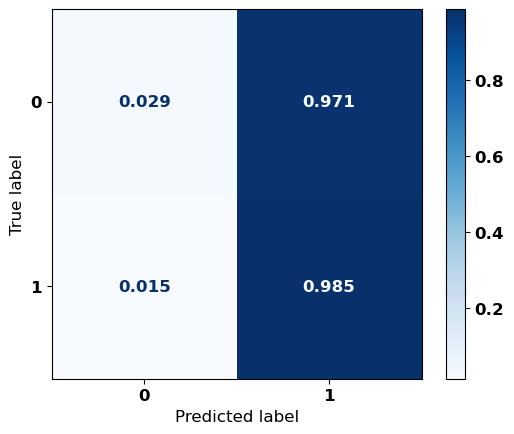


              precision    recall  f1-score   support

           0      0.807     0.029     0.056      9639
           1      0.325     0.985     0.489      4580

    accuracy                          0.337     14219
   macro avg      0.566     0.507     0.273     14219
weighted avg      0.652     0.337     0.196     14219



In [19]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

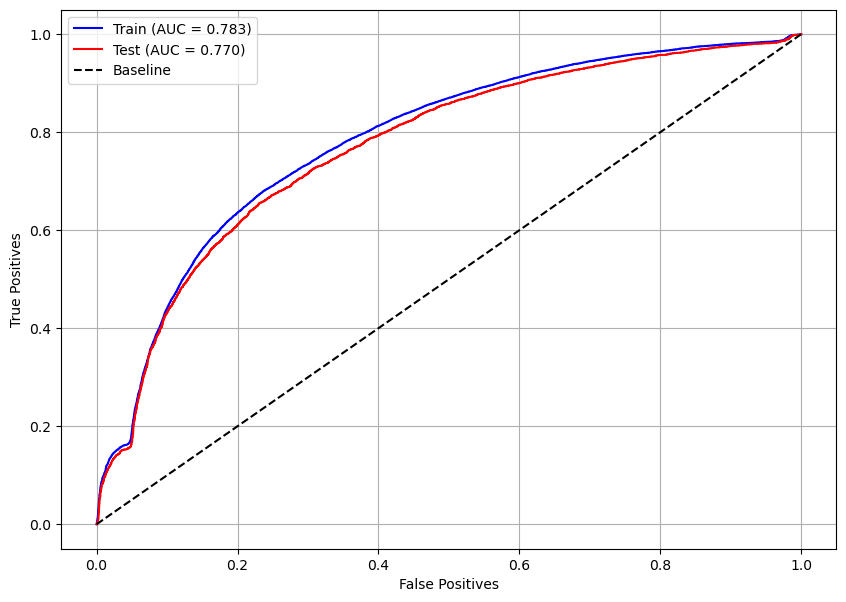

In [20]:

# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

In [66]:
class_weights = {0: 0.88, 1: 1}


rf = RandomForestClassifier(random_state=seed,
                            class_weight=class_weights,
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.88, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

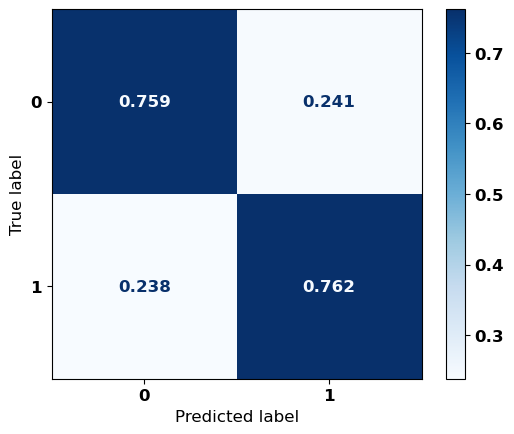


              precision    recall  f1-score   support

           0      0.870     0.759     0.811      9639
           1      0.600     0.762     0.671      4580

    accuracy                          0.760     14219
   macro avg      0.735     0.760     0.741     14219
weighted avg      0.783     0.760     0.766     14219



In [68]:
# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

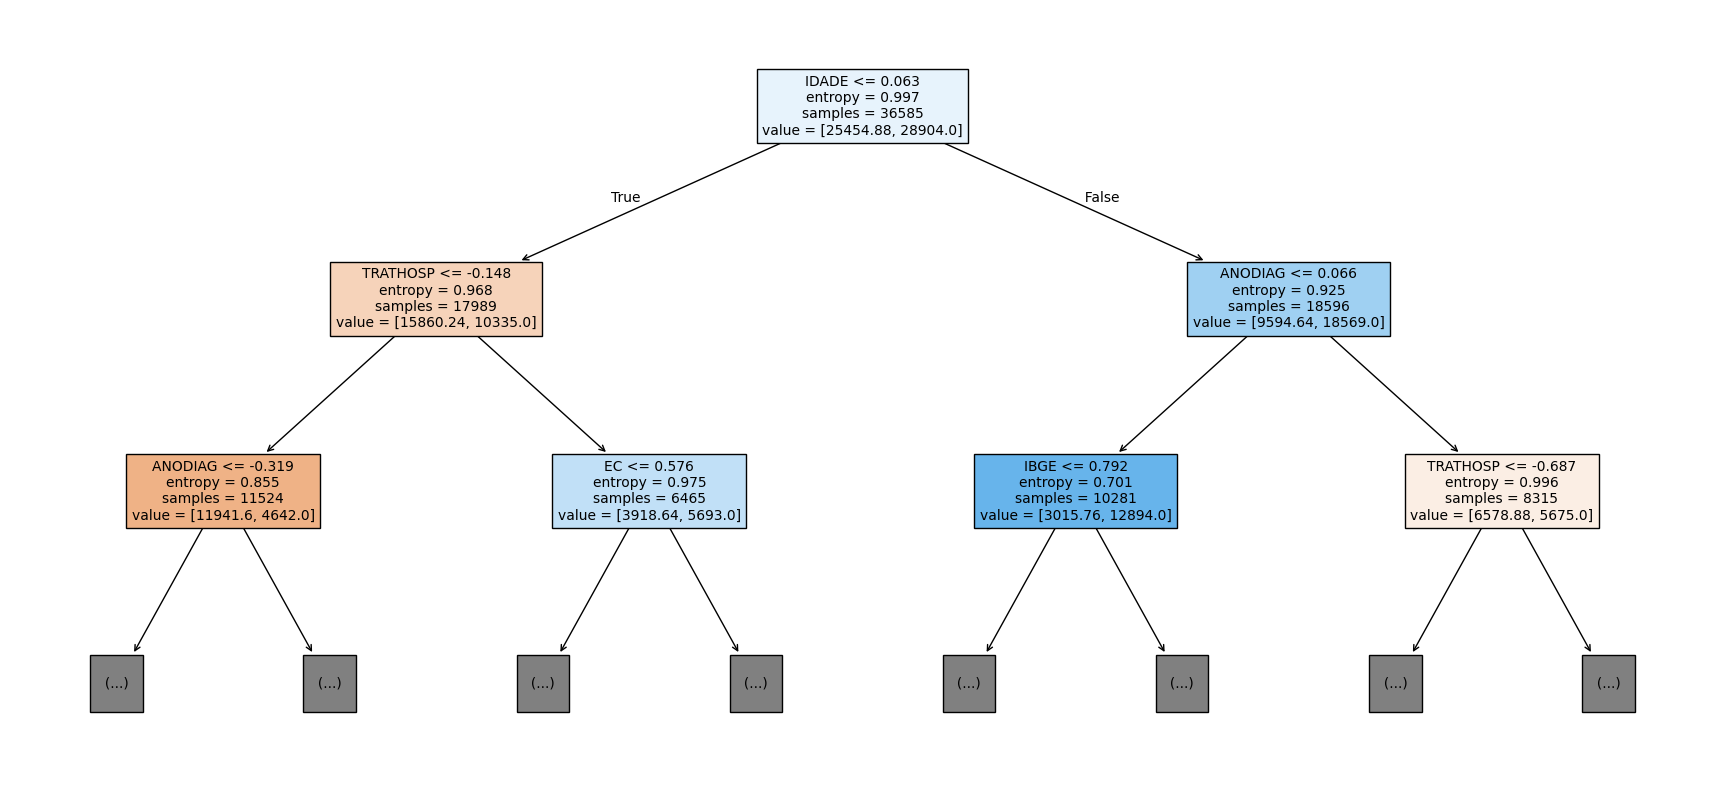

In [23]:
show_tree(rf, feat_cols, 2)


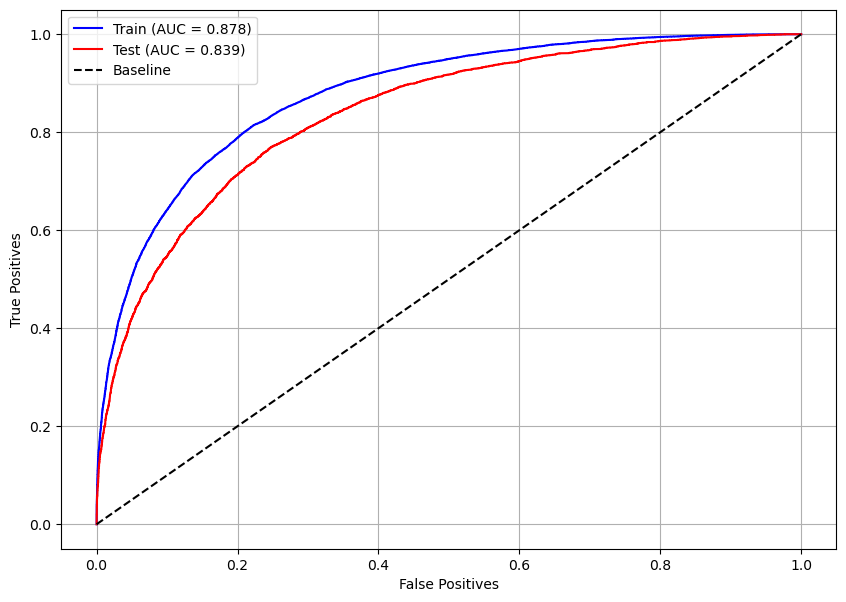

In [24]:
plot_roc_curve(rf, X_train, X_test, y_train, y_test)


In [25]:
def plot_feat_importances(model, feat_cols, n=10):
    feat_import = pd.Series(model.feature_importances_, index=feat_cols)
    feat_import.nlargest(n).plot(kind='barh', figsize=(10, 8))
    plt.show()

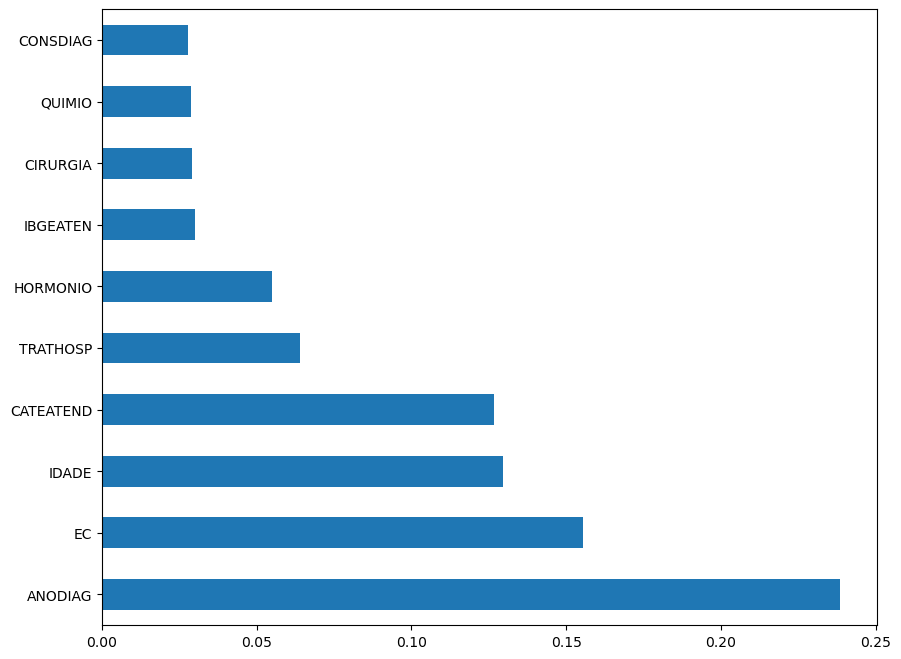

In [26]:
plot_feat_importances(rf, feat_cols)



# **XGBoost**

In [28]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=1.5,
                    random_state=seed)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=10, ...)

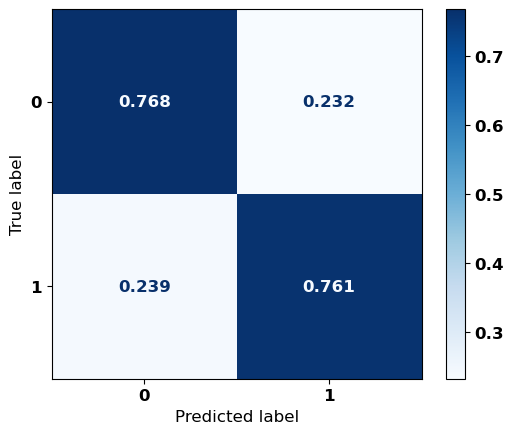


              precision    recall  f1-score   support

           0      0.871     0.768     0.816      9639
           1      0.609     0.761     0.676      4580

    accuracy                          0.765     14219
   macro avg      0.740     0.764     0.746     14219
weighted avg      0.787     0.765     0.771     14219



In [29]:
# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

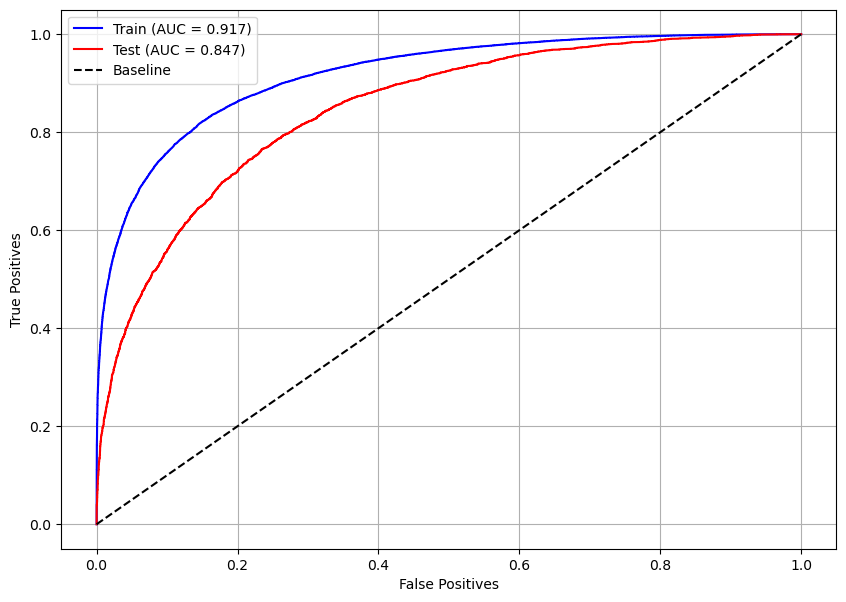

In [30]:
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)


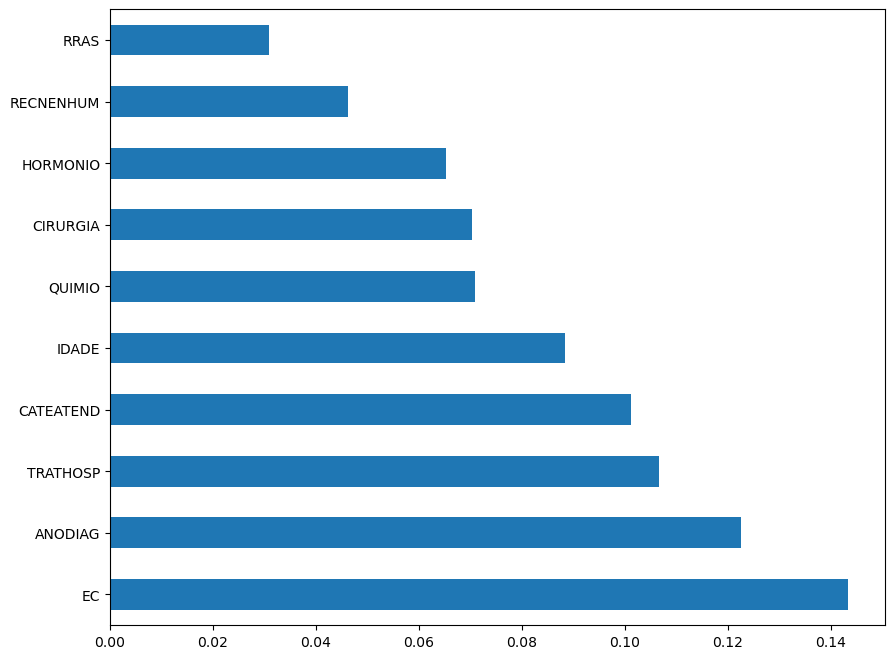

In [31]:
plot_feat_importances(xgb, feat_cols)


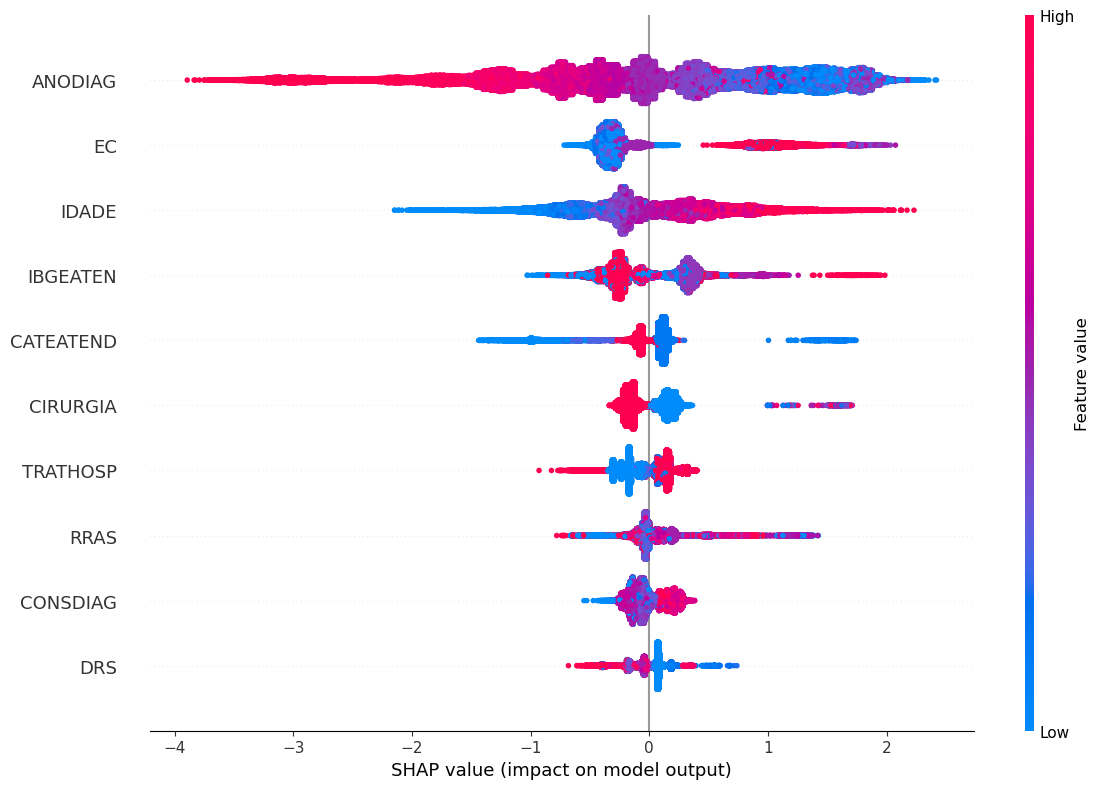

In [32]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)